<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [33]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
def get_dataloader(image_size, batch_size):

    root = 'D:/faces/'
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    dataset = ImageFolder(root, transform=tt.Compose([
        tt.Resize(image_size),
        tt.ToTensor(),
        tt.Normalize(*stats)
    ]))

    dataloader = DataLoader(dataset, batch_size, num_workers=3, pin_memory=True)

#   """
#   Builds dataloader for training data.
#   Use tt.Compose and tt.Resize for transformations
#   :param image_size: height and wdith of the image
#   :param batch_size: batch_size of the dataloader
#   :returns: DataLoader object 
#   """
    return dataloader
  # TODO: resize images, convert them to tensors and build dataloader

In [11]:
image_size = 128
batch_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#TODO: build dataloader and transfer it to device


In [12]:
dl = get_dataloader(image_size, batch_size)

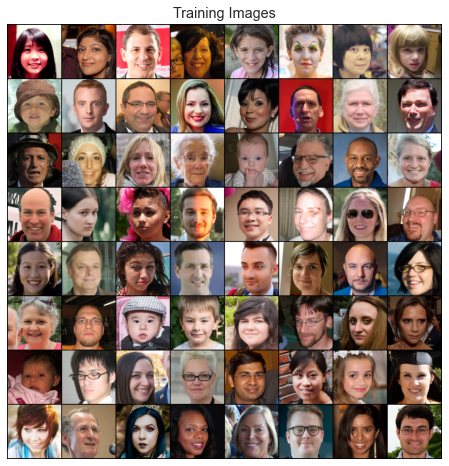

In [13]:
# Plot some training images
real_batch = next(iter(dl))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [21]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [22]:
# discriminator = nn.Sequential(
#     # in 3 x 128 x 128
    
#     nn.Conv2d(3, 256 , kernel_size=3, stride=3, padding=2, bias=False), # (128 - 3 + 4)/3  +1 = 44
#     nn.BatchNorm2d(256),
#     nn.ReLU(),  
    
#     # out 256 x 44 x 44
    
#     nn.Conv2d(256, 512, kernel_size=3, stride=3, padding=2, bias=False), # (44 - 3 + 4 )/ 3 +1 = 16
#     nn.BatchNorm2d(512),
#     nn.ReLU(), 
    
#     #out 512 x 16 x 16
    
#     nn.Conv2d(512, 1024, kernel_size=3, stride=3, padding=1, bias=False), # (16 - 3 + 2 )/ 3 +1 = 6
#     nn.BatchNorm2d(1024),
#     nn.ReLU(), 
    
#     #out 1024 x 6 x 6
    
#     nn.Conv2d(1024, 1 , kernel_size=6, stride=1 , padding=0, bias=False), # (6-6+0 )/1 +1 = 1
    
#     # out 1 x 1 x 1
#     nn.Flatten(),
#     nn.Sigmoid()
# )

In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
#         self.ngpu = ngpu
        self.main = nn.Sequential(
        # in 3 x 128 x 128

        nn.Conv2d(3, 256 , kernel_size=3, stride=3, padding=2, bias=False), # (128 - 3 + 4)/3  +1 = 44
        nn.BatchNorm2d(256),
        nn.ReLU(),  

        # out 256 x 44 x 44

        nn.Conv2d(256, 512, kernel_size=3, stride=3, padding=2, bias=False), # (44 - 3 + 4 )/ 3 +1 = 16
        nn.BatchNorm2d(512),
        nn.ReLU(), 

        #out 512 x 16 x 16

        nn.Conv2d(512, 1024, kernel_size=3, stride=3, padding=1, bias=False), # (16 - 3 + 2 )/ 3 +1 = 6
        nn.BatchNorm2d(1024),
        nn.ReLU(), 

        #out 1024 x 6 x 6

        nn.Conv2d(1024, 1 , kernel_size=6, stride=1 , padding=0, bias=False), # (6-6+0 )/1 +1 = 1

        # out 1 x 1 x 1
        nn.Flatten(),
        nn.Sigmoid()
    )
    def forward(self, input):
        return self.main(input)

In [24]:
latent_size = 512 # choose latent size


In [25]:
# generator = nn.Sequential(
#     # in latent_size  x 1 x 1
    
#     # out = (in - 1) x stride(1) - 2 x padding(0) + dilation(1) x (kernel(6) - 1) + output_padding + 1
    
#     nn.ConvTranspose2d(latent_size, 1024, kernel_size=6,
#                        stride=1, padding=0, bias=False), # (1-1)x1 - 2x0 + 1x5 + 0 +1 = 6
#     # out 1024 x 6 x 6
#     nn.BatchNorm2d(1024),
#     nn.ReLU(),
#     nn.UpsamplingBilinear2d(scale_factor=4), 
#     # out 6 x 4 = 24
#     nn.Conv2d(1024, 512 , kernel_size=2, stride=3 , padding=1),  # (24 - 2 + 2)/ 3 +1 = 9
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # out 512 x 9 x 9
    
#     nn.UpsamplingBilinear2d(scale_factor=4),
#     # 9 x 4 = 36
#     nn.Conv2d(512, 256, kernel_size=6, stride=2, padding=0, bias=False), # (36 - 6 + 0)/ 2 +1 = 16
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # 256 x 16 x 16
    
#     nn.UpsamplingBilinear2d(scale_factor=4),
#     # 16 x 4 = 64
#     nn.Conv2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), # (64 - 4 + 2)/ 2 +1 = 32
#     nn.BatchNorm2d(128),
#     nn.ReLU(True),
#     # 128 x 32 x 32
    
#     nn.UpsamplingBilinear2d(scale_factor=4),
#     # 32 x 4 = 128
#     nn.Conv2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), # (128 - 4 + 2)/ 2 +1 = 64
#     nn.BatchNorm2d(64),
#     nn.ReLU(True),
#     # 64 x 64 x 64
    
#     nn.UpsamplingBilinear2d(scale_factor=2),
#     # 64 x 2 = 128
#     nn.Conv2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False), # (128 - 4 + 2)/ 2 +1 = 64
#     nn.BatchNorm2d(32),
#     nn.ReLU(True),
#     # 32 x 64 x 64
    
#     nn.UpsamplingBilinear2d(scale_factor=4),
#     # 64 x 4 = 256
#     nn.Conv2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False), # (256 - 4 + 2)/ 2 +1 = 128
#     nn.BatchNorm2d(16),
#     nn.ReLU(True),
#     # 16 x 128 x 128
    
#     nn.ConvTranspose2d(16, 3, kernel_size=1, stride=1, padding=0, bias=False), # (127x1 - 0 + 1x(1-1) + 0 +1 = 128
#     nn.Tanh()
#     # out: 3 x 128 x 128
    

# )



In [26]:
class Generator(nn.Module):
    def __init__(self,):
        super(Generator, self).__init__()
#         self.ngpu = ngpu
        self.main = nn.Sequential(
        # in latent_size  x 1 x 1

        # out = (in - 1) x stride(1) - 2 x padding(0) + dilation(1) x (kernel(6) - 1) + output_padding + 1

        nn.ConvTranspose2d(latent_size, 1024, kernel_size=6,
                           stride=1, padding=0, bias=False), # (1-1)x1 - 2x0 + 1x5 + 0 +1 = 6
        # out 1024 x 6 x 6
        nn.BatchNorm2d(1024),
        nn.ReLU(),
        nn.UpsamplingBilinear2d(scale_factor=4), 
        # out 6 x 4 = 24
        nn.Conv2d(1024, 512 , kernel_size=2, stride=3 , padding=1),  # (24 - 2 + 2)/ 3 +1 = 9
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        # out 512 x 9 x 9

        nn.UpsamplingBilinear2d(scale_factor=4),
        # 9 x 4 = 36
        nn.Conv2d(512, 256, kernel_size=6, stride=2, padding=0, bias=False), # (36 - 6 + 0)/ 2 +1 = 16
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        # 256 x 16 x 16

        nn.UpsamplingBilinear2d(scale_factor=4),
        # 16 x 4 = 64
        nn.Conv2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), # (64 - 4 + 2)/ 2 +1 = 32
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # 128 x 32 x 32

        nn.UpsamplingBilinear2d(scale_factor=4),
        # 32 x 4 = 128
        nn.Conv2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), # (128 - 4 + 2)/ 2 +1 = 64
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # 64 x 64 x 64

        nn.UpsamplingBilinear2d(scale_factor=2),
        # 64 x 2 = 128
        nn.Conv2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False), # (128 - 4 + 2)/ 2 +1 = 64
        nn.BatchNorm2d(32),
        nn.ReLU(True),
        # 32 x 64 x 64

        nn.UpsamplingBilinear2d(scale_factor=4),
        # 64 x 4 = 256
        nn.Conv2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False), # (256 - 4 + 2)/ 2 +1 = 128
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        # 16 x 128 x 128

        nn.ConvTranspose2d(16, 3, kernel_size=1, stride=1, padding=0, bias=False), # (127x1 - 0 + 1x(1-1) + 0 +1 = 128
        nn.Tanh()
        # out: 3 x 128 x 128


    )

    def forward(self, input):
        return self.main(input)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [27]:
# Create the Discriminator
netD = Discriminator().to(device)



# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(3, 3), padding=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 512, kernel_size=(3, 3), stride=(3, 3), padding=(2, 2), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(1024, 1, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Sigmoid()
  )
)


In [36]:
# Create the generator
netG = Generator().to(device)



# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(512, 1024, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): UpsamplingBilinear2d(scale_factor=4.0, mode=bilinear)
    (4): Conv2d(1024, 512, kernel_size=(2, 2), stride=(3, 3), padding=(1, 1))
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): UpsamplingBilinear2d(scale_factor=4.0, mode=bilinear)
    (8): Conv2d(512, 256, kernel_size=(6, 6), stride=(2, 2), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): UpsamplingBilinear2d(scale_factor=4.0, mode=bilinear)
    (12): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inp

In [37]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [40]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 5
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dl, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dl),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dl)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/25]	Loss_D: 2.2170	Loss_G: 5.6226	D(x): 0.9998	D(G(z)): 0.7279 / 0.0221


KeyboardInterrupt: 

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [ ]:
def show_images(generated):
  # TODO: show generated images
  pass

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: